#### Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import STL
import statsmodels.tsa.holtwinters as hw
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.neural_network import MLPRegressor

#### Import Data

In [2]:
uk = pd.read_csv("C:/Users/erikc/Desktop/UK.csv")
uk2 = pd.read_csv("C:/Users/erikc/Desktop/UK.csv")
uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          184 non-null    object 
 1   Hydro_energy  184 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


#### Format date into something Python prefers

In [3]:
uk['Date'] = pd.to_datetime(uk['Date'], format = '%b-%y')

uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          184 non-null    datetime64[ns]
 1   Hydro_energy  184 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


#### Create splits for data as well as rolled up data for tuning models

In [4]:
print(uk.info())
uk_train = uk[0:167]
uk_valid = uk[167:180]
uk_tv = uk[0:180]
uk_test = uk[179:184]

print(uk_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          184 non-null    datetime64[ns]
 1   Hydro_energy  184 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB
None
          Date  Hydro_energy
179 2020-12-01       870.056
180 2021-01-01       773.333
181 2021-02-01       685.153
182 2021-03-01       792.451
183 2021-04-01       691.213


#### Pull month out of date for use later with SARIMAX

In [5]:
uk_train['Month'] = uk_train['Date'].dt.strftime('%b')

uk_valid['Month'] = uk_valid['Date'].dt.strftime('%b')

uk_tv['Month'] = uk_tv['Date'].dt.strftime('%b')

uk_test['Month'] = uk_test['Date'].dt.strftime('%b')

uk['Month'] = uk['Date'].dt.strftime('%b')

C:\Users\erikc\AppData\Local\Temp/ipykernel_60964/2831598124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_train['Month'] = uk_train['Date'].dt.strftime('%b')
C:\Users\erikc\AppData\Local\Temp/ipykernel_60964/2831598124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_valid['Month'] = uk_valid['Date'].dt.strftime('%b')
C:\Users\erikc\AppData\Local\Temp/ipykernel_60964/2831598124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

#### Set the index for time series use

In [6]:
uk_train.set_index('Date', inplace=True)

uk_valid.set_index('Date', inplace=True)

uk_tv.set_index('Date', inplace=True)

uk_test.set_index('Date', inplace=True)

#### Always plot your time series

<AxesSubplot:title={'center':'Hydroelectric Energy Usage in the UK'}>

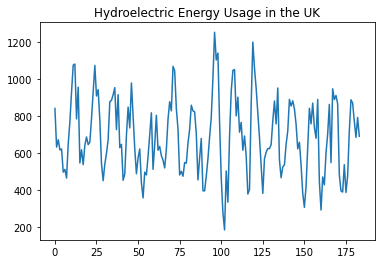

In [7]:
uk['Hydro_energy'].plot(title='Hydroelectric Energy Usage in the UK')

#### Decompose because it's good practice to get into

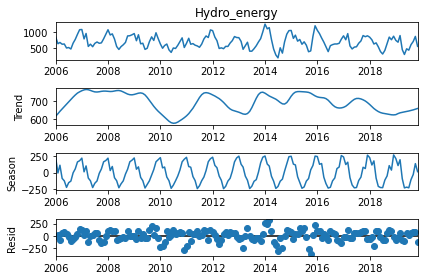

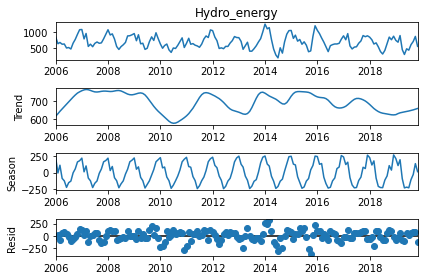

In [8]:
decompose_result = STL(uk_train['Hydro_energy'], seasonal = 13).fit()

decompose_result.plot()

#### Holt-Winters Additive

#### Start with an additive Holt-Winters model, get MAE and MAPE on validation data. Forecast will be used later for simple average forecast

In [9]:
hwes = hw.ExponentialSmoothing(uk_train['Hydro_energy'], seasonal='additive', seasonal_periods=12, initialization_method='estimated').fit()
print(hwes.summary())

C:\Users\erikc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                       ExponentialSmoothing Model Results                       
Dep. Variable:             Hydro_energy   No. Observations:                  167
Model:             ExponentialSmoothing   SSE                        2775002.886
Optimized:                         True   AIC                           1650.934
Trend:                             None   BIC                           1694.586
Seasonal:                      Additive   AICC                          1654.561
Seasonal Periods:                    12   Date:                 Thu, 02 Dec 2021
Box-Cox:                          False   Time:                         16:19:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6022250                alpha                 True
smoothing_seasonal       

#### Run same model on rolled up data to tune it to forecast onto test data

In [10]:
hwes_tv = hw.ExponentialSmoothing(uk_tv['Hydro_energy'], seasonal='additive', seasonal_periods=12, initialization_method='estimated').fit()
print(hwes.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             Hydro_energy   No. Observations:                  167
Model:             ExponentialSmoothing   SSE                        2775002.886
Optimized:                         True   AIC                           1650.934
Trend:                             None   BIC                           1694.586
Seasonal:                      Additive   AICC                          1654.561
Seasonal Periods:                    12   Date:                 Thu, 02 Dec 2021
Box-Cox:                          False   Time:                         16:19:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6022250                alpha                 True
smoothing_seasonal       

C:\Users\erikc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [11]:
hwes_full = hw.ExponentialSmoothing(uk['Hydro_energy'], seasonal='additive', seasonal_periods=12, initialization_method='estimated').fit()
print(hwes.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             Hydro_energy   No. Observations:                  167
Model:             ExponentialSmoothing   SSE                        2775002.886
Optimized:                         True   AIC                           1650.934
Trend:                             None   BIC                           1694.586
Seasonal:                      Additive   AICC                          1654.561
Seasonal Periods:                    12   Date:                 Thu, 02 Dec 2021
Box-Cox:                          False   Time:                         16:19:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6022250                alpha                 True
smoothing_seasonal       

#### Get forecasts from above models

In [12]:
y_hat_HWES = hwes.forecast(steps = 13)
print(y_hat_HWES)

2019-12-01    769.689139
2020-01-01    767.153865
2020-02-01    627.279457
2020-03-01    643.434266
2020-04-01    473.594561
2020-05-01    404.588993
2020-06-01    316.125444
2020-07-01    354.367901
2020-08-01    439.147570
2020-09-01    501.851018
2020-10-01    614.048444
2020-11-01    694.460163
2020-12-01    769.689139
Freq: MS, dtype: float64


In [13]:
y_hat_HWES_tv = hwes_tv.forecast(steps=5)
print(y_hat_HWES_tv)

2021-01-01    883.758877
2021-02-01    756.620479
2021-03-01    762.380999
2021-04-01    574.884689
2021-05-01    507.587534
Freq: MS, dtype: float64


In [14]:
y_hat_HWES_full = hwes_full.forecast(steps=6)
print(y_hat_HWES_full)

184    565.200832
185    479.700649
186    517.793970
187    577.800589
188    640.593847
189    759.954086
dtype: float64


#### SARIMAX

#### Create dummies for SARIMAX

In [15]:
#Train
#January
uk_train.loc[uk_train['Month'] == 'Jan', 'Jan'] = 1
uk_train.loc[uk_train['Month'] != 'Jan', 'Jan'] = 0

#February
uk_train.loc[uk_train['Month'] == 'Feb', 'Feb'] = 1
uk_train.loc[uk_train['Month'] != 'Feb', 'Feb'] = 0

#March
uk_train.loc[uk_train['Month'] == 'Mar', 'Mar'] = 1
uk_train.loc[uk_train['Month'] != 'Mar', 'Mar'] = 0

#April
uk_train.loc[uk_train['Month'] == 'Apr', 'Apr'] = 1
uk_train.loc[uk_train['Month'] != 'Apr', 'Apr'] = 0

#May
uk_train.loc[uk_train['Month'] == 'May', 'May'] = 1
uk_train.loc[uk_train['Month'] != 'May', 'May'] = 0

#June
uk_train.loc[uk_train['Month'] == 'Jun', 'Jun'] = 1
uk_train.loc[uk_train['Month'] != 'Jun', 'Jun'] = 0

#July
uk_train.loc[uk_train['Month'] == 'Jul', 'Jul'] = 1
uk_train.loc[uk_train['Month'] != 'Jul', 'Jul'] = 0

#August
uk_train.loc[uk_train['Month'] == 'Aug', 'Aug'] = 1
uk_train.loc[uk_train['Month'] != 'Aug', 'Aug'] = 0

#September
uk_train.loc[uk_train['Month'] == 'Sep', 'Sep'] = 1
uk_train.loc[uk_train['Month'] != 'Sep', 'Sep'] = 0

#October
uk_train.loc[uk_train['Month'] == 'Oct', 'Oct'] = 1
uk_train.loc[uk_train['Month'] != 'Oct', 'Oct'] = 0

#November
uk_train.loc[uk_train['Month'] == 'Nov', 'Nov'] = 1
uk_train.loc[uk_train['Month'] != 'Nov', 'Nov'] = 0

#December
uk_train.loc[uk_train['Month'] == 'Dec', 'Dec'] = 1
uk_train.loc[uk_train['Month'] != 'Dec', 'Dec'] = 0

#Train/Validate Roll Up
#January
uk_tv.loc[uk_tv['Month'] == 'Jan', 'Jan'] = 1
uk_tv.loc[uk_tv['Month'] != 'Jan', 'Jan'] = 0

#February
uk_tv.loc[uk_tv['Month'] == 'Feb', 'Feb'] = 1
uk_tv.loc[uk_tv['Month'] != 'Feb', 'Feb'] = 0

#March
uk_tv.loc[uk_tv['Month'] == 'Mar', 'Mar'] = 1
uk_tv.loc[uk_tv['Month'] != 'Mar', 'Mar'] = 0

#April
uk_tv.loc[uk_tv['Month'] == 'Apr', 'Apr'] = 1
uk_tv.loc[uk_tv['Month'] != 'Apr', 'Apr'] = 0

#May
uk_tv.loc[uk_tv['Month'] == 'May', 'May'] = 1
uk_tv.loc[uk_tv['Month'] != 'May', 'May'] = 0

#June
uk_tv.loc[uk_tv['Month'] == 'Jun', 'Jun'] = 1
uk_tv.loc[uk_tv['Month'] != 'Jun', 'Jun'] = 0

#July
uk_tv.loc[uk_tv['Month'] == 'Jul', 'Jul'] = 1
uk_tv.loc[uk_tv['Month'] != 'Jul', 'Jul'] = 0

#August
uk_tv.loc[uk_tv['Month'] == 'Aug', 'Aug'] = 1
uk_tv.loc[uk_tv['Month'] != 'Aug', 'Aug'] = 0

#September
uk_tv.loc[uk_tv['Month'] == 'Sep', 'Sep'] = 1
uk_tv.loc[uk_tv['Month'] != 'Sep', 'Sep'] = 0

#October
uk_tv.loc[uk_tv['Month'] == 'Oct', 'Oct'] = 1
uk_tv.loc[uk_tv['Month'] != 'Oct', 'Oct'] = 0

#November
uk_tv.loc[uk_tv['Month'] == 'Nov', 'Nov'] = 1
uk_tv.loc[uk_tv['Month'] != 'Nov', 'Nov'] = 0

#December
uk_tv.loc[uk_tv['Month'] == 'Dec', 'Dec'] = 1
uk_tv.loc[uk_tv['Month'] != 'Dec', 'Dec'] = 0

#Full Roll Up
#January
uk.loc[uk['Month'] == 'Jan', 'Jan'] = 1
uk.loc[uk['Month'] != 'Jan', 'Jan'] = 0

#February
uk.loc[uk['Month'] == 'Feb', 'Feb'] = 1
uk.loc[uk['Month'] != 'Feb', 'Feb'] = 0

#March
uk.loc[uk['Month'] == 'Mar', 'Mar'] = 1
uk.loc[uk['Month'] != 'Mar', 'Mar'] = 0

#April
uk.loc[uk['Month'] == 'Apr', 'Apr'] = 1
uk.loc[uk['Month'] != 'Apr', 'Apr'] = 0

#May
uk.loc[uk['Month'] == 'May', 'May'] = 1
uk.loc[uk['Month'] != 'May', 'May'] = 0

#June
uk.loc[uk['Month'] == 'Jun', 'Jun'] = 1
uk.loc[uk['Month'] != 'Jun', 'Jun'] = 0

#July
uk.loc[uk['Month'] == 'Jul', 'Jul'] = 1
uk.loc[uk['Month'] != 'Jul', 'Jul'] = 0

#August
uk.loc[uk['Month'] == 'Aug', 'Aug'] = 1
uk.loc[uk['Month'] != 'Aug', 'Aug'] = 0

#September
uk.loc[uk['Month'] == 'Sep', 'Sep'] = 1
uk.loc[uk['Month'] != 'Sep', 'Sep'] = 0

#October
uk.loc[uk['Month'] == 'Oct', 'Oct'] = 1
uk.loc[uk['Month'] != 'Oct', 'Oct'] = 0

#November
uk.loc[uk['Month'] == 'Nov', 'Nov'] = 1
uk.loc[uk['Month'] != 'Nov', 'Nov'] = 0

#December
uk.loc[uk['Month'] == 'Dec', 'Dec'] = 1
uk.loc[uk['Month'] != 'Dec', 'Dec'] = 0

C:\Users\erikc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\erikc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### Run auto_arima for p,d,q and P,D,Q terms

In [16]:
pm.auto_arima(uk['Hydro_energy'], m=12, information_criterion='bic', seasonal_test='ch')

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

#### Run SARIMAX with exogenous dummy variables

In [17]:
endog = uk_train[['Hydro_energy']]
exog = uk_train[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

sarimax = SARIMAX(endog, exog, order = (1, 0, 0), seasonal_order = (2, 0, 0, 12), m=12).fit()
print(sarimax.summary())

C:\Users\erikc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\erikc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                       Hydro_energy   No. Observations:                  167
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1027.855
Date:                            Thu, 02 Dec 2021   AIC                           2087.709
Time:                                    16:19:40   BIC                           2137.597
Sample:                                01-01-2006   HQIC                          2107.957
                                     - 11-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Jan          922.9667     31.288     29.499      0.000     861.644     984.289
Feb          781.5942     42.705   

#### Run SARIMAX on rolled up data

In [18]:
endog1 = uk_tv[['Hydro_energy']]
exog1 = uk_tv[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

sarimax_tv = SARIMAX(endog1, exog1, order = (1, 0, 0), seasonal_order = (2, 0, 0, 12), m=12).fit()
print(sarimax_tv.summary())

C:\Users\erikc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\erikc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                       Hydro_energy   No. Observations:                  180
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1107.153
Date:                            Thu, 02 Dec 2021   AIC                           2246.305
Time:                                    16:19:41   BIC                           2297.393
Sample:                                01-01-2006   HQIC                          2267.019
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Jan          919.6165     29.679     30.986      0.000     861.448     977.785
Feb          790.0691     38.503   

In [19]:
endog_f = uk[['Hydro_energy']]
exog_f = uk[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

sarimax_full = SARIMAX(endog_f, exog_f, order = (1, 0, 0), seasonal_order = (2, 0, 0, 12), m=12).fit()
print(sarimax_tv.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Hydro_energy   No. Observations:                  180
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1107.153
Date:                            Thu, 02 Dec 2021   AIC                           2246.305
Time:                                    16:19:41   BIC                           2297.393
Sample:                                01-01-2006   HQIC                          2267.019
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Jan          919.6165     29.679     30.986      0.000     861.448     977.785
Feb          790.0691     38.503   

#### Get forecasts from both SARIMAX

In [20]:
fore_exog = sarimax.forecast(steps=167, exog=exog)

y_hat_sarimax = pd.DataFrame(fore_exog)

y_hat_sarimax = y_hat_sarimax[0:13]

print(y_hat_sarimax)

            predicted_mean
2019-12-01      782.546563
2020-01-01      717.904424
2020-02-01      767.117955
2020-03-01      593.999945
2020-04-01      552.972228
2020-05-01      466.956027
2020-06-01      485.584739
2020-07-01      564.869498
2020-08-01      622.179006
2020-09-01      734.543270
2020-10-01      818.748608
2020-11-01      921.639170
2020-12-01      930.216627


In [21]:
fore_exog_tv = sarimax_tv.forecast(steps=167, exog=exog)

y_hat_sarimax_tv = pd.DataFrame(fore_exog_tv)

y_hat_sarimax_tv = y_hat_sarimax_tv[0:5]

print(y_hat_sarimax_tv)

            predicted_mean
2021-01-01      898.331251
2021-02-01      773.134349
2021-03-01      796.657610
2021-04-01      615.414226
2021-05-01      543.179507


In [22]:
error_sarimax_full = uk_test['Hydro_energy'] - y_hat_sarimax_tv['predicted_mean']

In [23]:
print(np.mean(abs(error_sarimax_full)))
print(np.mean(abs(error_sarimax_full)/abs(uk_test['Hydro_energy'])))

73.24624604693423
0.10125396305763026


In [24]:
fore_exog_full = sarimax_full.forecast(steps=184, exog=exog_f)

y_hat_sarimax_full = pd.DataFrame(fore_exog_full)

y_hat_sarimax_full = y_hat_sarimax_full[0:6]

print(y_hat_sarimax_full)

     predicted_mean
184      947.045226
185      803.104416
186      807.167993
187      631.540463
188      550.873552
189      456.704713


In [25]:
comb = (y_hat_sarimax_tv['predicted_mean'] + y_hat_HWES_tv)/2 
print(comb)

2021-01-01    891.045064
2021-02-01    764.877414
2021-03-01    779.519305
2021-04-01    595.149458
2021-05-01    525.383521
Freq: MS, dtype: float64


In [26]:
comb_err = uk_test['Hydro_energy'] - comb

In [27]:
print(np.mean(abs(comb_err)))
print(np.mean(abs(comb_err)/abs(uk_test['Hydro_energy'])))

76.60792887207063
0.10596769205407625


#### Neural Network Modeling

#### Build the variables you need for the neural network

In [28]:
uk_train['Lag1'] = uk_train['Hydro_energy'].shift(periods=1)
uk_train['s_lag1'] = uk_train['Hydro_energy'].shift(periods=12)
uk_train['s_lag2'] = uk_train['Hydro_energy'].shift(periods=24)

uk_train2 = uk_train.dropna()

print(uk_train2.head())

            Hydro_energy Month  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  \
Date                                                                          
2008-01-01      1073.177   Jan  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2008-02-01       908.278   Feb  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2008-03-01       942.656   Mar  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2008-04-01       779.457   Apr  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2008-05-01       544.375   May  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

            Oct  Nov  Dec      Lag1    s_lag1   s_lag2  
Date                                                    
2008-01-01  0.0  0.0  0.0   930.103  1080.437  841.074  
2008-02-01  0.0  0.0  0.0  1073.177   784.808  632.962  
2008-03-01  0.0  0.0  0.0   908.278   955.707  672.459  
2008-04-01  0.0  0.0  0.0   942.656   547.182  617.138  
2008-05-01  0.0  0.0  0.0   779.457   618.498  623.144  


<ipython-input-28-f6958cb08617>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_train['Lag1'] = uk_train['Hydro_energy'].shift(periods=1)
<ipython-input-28-f6958cb08617>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_train['s_lag1'] = uk_train['Hydro_energy'].shift(periods=12)
<ipython-input-28-f6958cb08617>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

#### Make x and y variables as well as a validation dataset

In [29]:
y = uk_train2[['Hydro_energy']]
x = uk_train2.drop(['Hydro_energy', 'Month'], axis=1)

uk_valid2 = uk[167:180]

#### Build the neural network model for use with data

In [30]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=8, random_state=1)

#### Fit the model to the data

In [31]:
o = clf.fit(x,y)

C:\Users\erikc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\erikc\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### Get parameters and rename the column as predicted

In [32]:
print(o.get_params())

z = pd.DataFrame(o.predict(x), columns=['predicted'])

{'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 8, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


#### Create dataframe of predicted versus actual

In [33]:
uk2_a = uk2[25:168]

print(uk2_a.info())

y_1 = uk2[['Hydro_energy']]

u = pd.concat([z, y_1], join='inner', axis=1)

print(u)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 25 to 167
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Hydro_energy  143 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB
None
      predicted  Hydro_energy
0    924.763214       841.074
1    866.387193       632.962
2    848.704966       672.459
3    703.740703       617.138
4    619.123494       623.144
..          ...           ...
138  490.982871       536.857
139  544.490246       647.853
140  650.247606       720.220
141  791.965060       890.102
142  875.044816       854.095

[143 rows x 2 columns]


#### Create error dataframe

In [34]:
err_nn = u['Hydro_energy'] - u['predicted']

print(err_nn)

0      -83.689214
1     -233.425193
2     -176.245966
3      -86.602703
4        4.020506
          ...    
138     45.874129
139    103.362754
140     69.972394
141     98.136940
142    -20.949816
Length: 143, dtype: float64


#### Caluclate MAE and MAPE

In [35]:
print(np.mean(abs(err_nn)))
print(np.mean(abs(err_nn)/abs(uk2['Hydro_energy'])))

123.40622202319265
0.19814937770240953
